In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
# global variables

look_back = 20
lead_time = 3
filename = '../../../data/Arctic_Monthy_Mean_1979_2021.csv'

In [3]:
# from google.colab import files
# import io

# uploaded = files.upload()
# df = pd.read_csv(io.BytesIO(uploaded[filename]))

# Reading the dataset
df = pd.read_csv(filename)
df.head()

Date  wind_10m  specific_humidity     LW_down     SW_down  rainfall  \
0  1/1/1979  5.531398           0.811961  186.687054    3.127880  1.009872   
1  2/1/1979  5.328020           0.688896  174.794571   18.541594  0.920831   
2  3/1/1979  5.432511           0.916124  190.741933   67.690429  0.983327   
3  4/1/1979  4.792836           1.272056  212.937925  156.223673  0.890723   
4  5/1/1979  4.819028           2.239776  253.690478  230.950833  1.201308   

   snowfall         sst         t2m  surface_pressure  sea_ice_extent  
0  0.892319  273.355237  250.388101        984.633032        15604191  
1  0.781347  273.121885  247.071202        983.980418        16378929  
2  0.855266  273.088099  252.954138        985.140468        16521089  
3  0.705203  273.126062  259.557456        989.314698        15561238  
4  0.688723  273.393551  269.375118        984.483658        14085613

In [4]:
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df.set_index('Date', inplace=True)
df = df.astype(float)                 # cast df to float
df.tail(len(df))

wind_10m  specific_humidity     LW_down     SW_down  rainfall  \
Date                                                                        
1979-01-01  5.531398           0.811961  186.687054    3.127880  1.009872   
1979-02-01  5.328020           0.688896  174.794571   18.541594  0.920831   
1979-03-01  5.432511           0.916124  190.741933   67.690429  0.983327   
1979-04-01  4.792836           1.272056  212.937925  156.223673  0.890723   
1979-05-01  4.819028           2.239776  253.690478  230.950833  1.201308   
...              ...                ...         ...         ...       ...   
2021-04-01  5.383687           1.529497  225.171796  156.567743  1.159049   
2021-05-01  4.777020           2.451088  260.956781  229.604138  1.077705   
2021-06-01  4.771453           4.176458  294.931709  244.702852  1.585094   
2021-07-01  4.754014           5.193846  313.311345  196.774631  1.957911   
2021-08-01  4.635243           5.077386  313.003568  126.146891  2.046782   

            snowfall         sst         t2m  surface_pressure  sea_ice_extent  
Date                                                                            
1979-01-01  0.892319  273.355237  250.388101        984.633032      15604191.0  
1979-02-01  0.781347  273.121885  247.071202        983.980418      16378929.0  
1979-03-01  0.855266  273.088099  252.954138        985.140468      16521089.0  
1979-04-01  0.705203  273.126062  259.557456        989.314698      15561238.0  
1979-05-01  0.688723  273.393551  269.375118        984.483658      14085613.0  
...              ...         ...         ...               ...             ...  
2021-04-01  0.929777  273.470298  263.146395        985.801841      13840000.0  
2021-05-01  0.575494  273.888627  271.557464        985.606182      12660000.0  
2021-06-01  0.360146  275.245088  278.360921        978.436682      10710000.0  
2021-07-01  0.248088  277.253314  280.413695        978.293303       7690000.0  
2021-08-01  0.235519  278.556142  279.556077        980.453507       5750000.0  

[512 rows x 10 columns]

In [5]:
def create_model_data (dataset, look_back, lead_time):
    dataX, dataY = [], []
    
    for i in range(len(dataset)-look_back-lead_time):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back + (lead_time-1)])
    return np.array(dataX), np.array(dataY)

In [6]:
target_index = df.columns.tolist().index('sea_ice_extent')

dataset = df.values.astype('float32')               # DataFrame converted to Numpy Array

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

X, y = create_model_data (dataset, look_back=look_back, lead_time=lead_time)
y = y[:,target_index]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

<function matplotlib.pyplot.show(*args, **kw)>

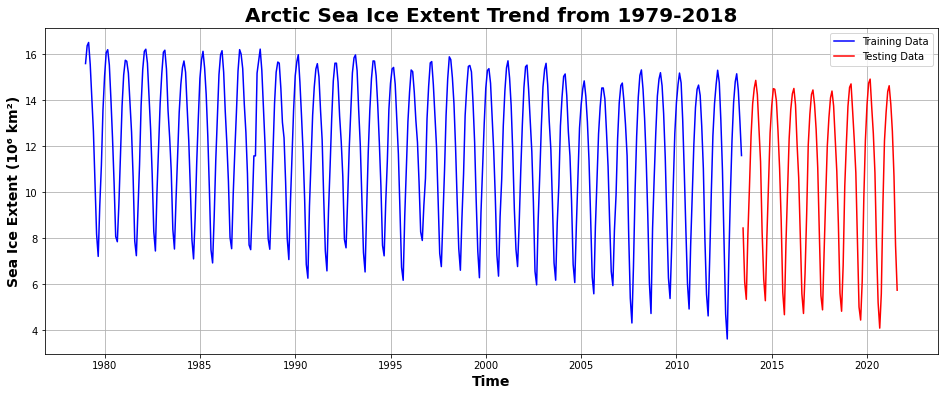

In [8]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Trend from 1979-2018', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(df['sea_ice_extent'][:len(df)-len(y_test)]/10**6, 'blue', label='Training Data')
plt.plot(df['sea_ice_extent'][len(df)-len(y_test):]/10**6, 'red', label='Testing Data')
plt.legend()
plt.grid()
plt.show

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, LSTM, GRU, Dense

input_shape=(X.shape[1], X.shape[2])

model = Sequential()
model.add(GRU(64, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(128, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(256, return_sequences=True))
model.add(Dropout(0.2))

model.add(GRU(512, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(1024, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(512, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128))
model.add(Dropout(0.2))

model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mse'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 20, 64)            14592     
                                                                 
 dropout (Dropout)           (None, 20, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 20, 128)           74496     
                                                                 
 dropout_1 (Dropout)         (None, 20, 128)           0         
                                                                 
 gru_2 (GRU)                 (None, 20, 256)           296448    
                                                                 
 dropout_2 (Dropout)         (None, 20, 256)           0         
                                                                 
 gru_3 (GRU)                 (None, 20, 512)           1

In [10]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("weights.best.hdf5", monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')

callbacks_list = [checkpoint]
history = model.fit(X_train, y_train, epochs=100, batch_size=64, verbose=1, callbacks=callbacks_list, validation_split=0.1)

Epoch 1/100
6/6 [==============================] - ETA: 0s - loss: 1.1664 - mae: 0.8155 - mse: 1.1664

6/6 [==============================] - 21s 524ms/step - loss: 1.1664 - mae: 0.8155 - mse: 1.1664 - val_loss: 0.3322 - val_mae: 0.5104 - val_mse: 0.3322
Epoch 2/100
5/6 [========================>.....] - ETA: 0s - loss: 0.2555 - mae: 0.4383 - mse: 0.2555

6/6 [==============================] - 0s 55ms/step - loss: 0.2466 - mae: 0.4285 - mse: 0.2466 - val_loss: 0.1434 - val_mae: 0.2732 - val_mse: 0.1434
Epoch 3/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0731 - mae: 0.2260 - mse: 0.0731

6/6 [==============================] - 0s 45ms/step - loss: 0.0710 - mae: 0.2227 - mse: 0.0710 - val_loss: 0.1353 - val_mae: 0.2643 - val_mse: 0.1353
Epoch 4/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0749 - mae: 0.2270 - mse: 0.0749

6/6 [==============================] - 0s 46ms/step - loss: 0.0746 - mae: 0.2262 - mse: 0.0746 - val_loss: 0.0827 - val_mae: 0.2289 - val_mse: 0.0827
Epoch 5/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0660 - mae: 0.2149 - mse: 0.0660

6/6 [==============================] - 0s 45ms/step - loss: 0.0645 - mae: 0.2133 - mse: 0.0645 - val_loss: 0.0721 - val_mae: 0.2294 - val_mse: 0.0721
Epoch 6/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0537 - mae: 0.1909 - mse: 0.0537

6/6 [==============================] - 0s 44ms/step - loss: 0.0532 - mae: 0.1894 - mse: 0.0532 - val_loss: 0.0555 - val_mae: 0.1805 - val_mse: 0.0555
Epoch 7/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0440 - mae: 0.1730 - mse: 0.0440

6/6 [==============================] - 0s 46ms/step - loss: 0.0433 - mae: 0.1714 - mse: 0.0433 - val_loss: 0.0598 - val_mae: 0.1790 - val_mse: 0.0598
Epoch 8/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0317 - mae: 0.1421 - mse: 0.0317

6/6 [==============================] - 0s 46ms/step - loss: 0.0303 - mae: 0.1384 - mse: 0.0303 - val_loss: 0.0438 - val_mae: 0.1710 - val_mse: 0.0438
Epoch 9/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0192 - mae: 0.1077 - mse: 0.0192

6/6 [==============================] - 0s 45ms/step - loss: 0.0189 - mae: 0.1070 - mse: 0.0189 - val_loss: 0.0204 - val_mae: 0.1226 - val_mse: 0.0204
Epoch 10/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0147 - mae: 0.0971 - mse: 0.0147

6/6 [==============================] - 0s 45ms/step - loss: 0.0160 - mae: 0.1009 - mse: 0.0160 - val_loss: 0.0213 - val_mae: 0.1191 - val_mse: 0.0213
Epoch 11/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0182 - mae: 0.1084 - mse: 0.0182

6/6 [==============================] - 0s 45ms/step - loss: 0.0177 - mae: 0.1066 - mse: 0.0177 - val_loss: 0.0134 - val_mae: 0.0883 - val_mse: 0.0134
Epoch 12/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0120 - mae: 0.0875 - mse: 0.0120

6/6 [==============================] - 0s 46ms/step - loss: 0.0120 - mae: 0.0871 - mse: 0.0120 - val_loss: 0.0174 - val_mae: 0.0967 - val_mse: 0.0174
Epoch 13/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0111 - mae: 0.0834 - mse: 0.0111

6/6 [==============================] - 0s 45ms/step - loss: 0.0111 - mae: 0.0837 - mse: 0.0111 - val_loss: 0.0192 - val_mae: 0.1096 - val_mse: 0.0192
Epoch 14/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0120 - mae: 0.0864 - mse: 0.0120

6/6 [==============================] - 0s 43ms/step - loss: 0.0115 - mae: 0.0847 - mse: 0.0115 - val_loss: 0.0179 - val_mae: 0.1164 - val_mse: 0.0179
Epoch 15/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0101 - mae: 0.0811 - mse: 0.0101

6/6 [==============================] - 0s 45ms/step - loss: 0.0109 - mae: 0.0840 - mse: 0.0109 - val_loss: 0.0147 - val_mae: 0.0881 - val_mse: 0.0147
Epoch 16/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0118 - mae: 0.0854 - mse: 0.0118

6/6 [==============================] - 0s 44ms/step - loss: 0.0116 - mae: 0.0845 - mse: 0.0116 - val_loss: 0.0166 - val_mae: 0.1119 - val_mse: 0.0166
Epoch 17/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0093 - mae: 0.0770 - mse: 0.0093

6/6 [==============================] - 0s 45ms/step - loss: 0.0091 - mae: 0.0765 - mse: 0.0091 - val_loss: 0.0184 - val_mae: 0.1026 - val_mse: 0.0184
Epoch 18/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0084 - mae: 0.0734 - mse: 0.0084

6/6 [==============================] - 0s 44ms/step - loss: 0.0084 - mae: 0.0740 - mse: 0.0084 - val_loss: 0.0100 - val_mae: 0.0884 - val_mse: 0.0100
Epoch 19/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0085 - mae: 0.0725 - mse: 0.0085

6/6 [==============================] - 0s 46ms/step - loss: 0.0085 - mae: 0.0725 - mse: 0.0085 - val_loss: 0.0171 - val_mae: 0.0985 - val_mse: 0.0171
Epoch 20/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0079 - mae: 0.0705 - mse: 0.0079

6/6 [==============================] - 0s 45ms/step - loss: 0.0078 - mae: 0.0704 - mse: 0.0078 - val_loss: 0.0108 - val_mae: 0.0869 - val_mse: 0.0108
Epoch 21/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0084 - mae: 0.0721 - mse: 0.0084

6/6 [==============================] - 0s 45ms/step - loss: 0.0085 - mae: 0.0732 - mse: 0.0085 - val_loss: 0.0197 - val_mae: 0.1216 - val_mse: 0.0197
Epoch 22/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0078 - mae: 0.0681 - mse: 0.0078

6/6 [==============================] - 0s 46ms/step - loss: 0.0077 - mae: 0.0681 - mse: 0.0077 - val_loss: 0.0160 - val_mae: 0.1151 - val_mse: 0.0160
Epoch 23/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0071 - mae: 0.0677 - mse: 0.0071

6/6 [==============================] - 0s 46ms/step - loss: 0.0071 - mae: 0.0680 - mse: 0.0071 - val_loss: 0.0080 - val_mae: 0.0718 - val_mse: 0.0080
Epoch 24/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0082 - mae: 0.0736 - mse: 0.0082

6/6 [==============================] - 0s 44ms/step - loss: 0.0079 - mae: 0.0723 - mse: 0.0079 - val_loss: 0.0062 - val_mae: 0.0580 - val_mse: 0.0062
Epoch 25/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0074 - mae: 0.0694 - mse: 0.0074

6/6 [==============================] - 0s 44ms/step - loss: 0.0073 - mae: 0.0694 - mse: 0.0073 - val_loss: 0.0080 - val_mae: 0.0651 - val_mse: 0.0080
Epoch 26/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0064 - mae: 0.0631 - mse: 0.0064

6/6 [==============================] - 0s 44ms/step - loss: 0.0063 - mae: 0.0625 - mse: 0.0063 - val_loss: 0.0096 - val_mae: 0.0778 - val_mse: 0.0096
Epoch 27/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0060 - mae: 0.0605 - mse: 0.0060

6/6 [==============================] - 0s 45ms/step - loss: 0.0059 - mae: 0.0603 - mse: 0.0059 - val_loss: 0.0036 - val_mae: 0.0472 - val_mse: 0.0036
Epoch 28/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0063 - mae: 0.0640 - mse: 0.0063

6/6 [==============================] - 0s 45ms/step - loss: 0.0063 - mae: 0.0643 - mse: 0.0063 - val_loss: 0.0085 - val_mae: 0.0614 - val_mse: 0.0085
Epoch 29/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0056 - mae: 0.0596 - mse: 0.0056

6/6 [==============================] - 0s 45ms/step - loss: 0.0056 - mae: 0.0595 - mse: 0.0056 - val_loss: 0.0136 - val_mae: 0.1049 - val_mse: 0.0136
Epoch 30/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0058 - mae: 0.0595 - mse: 0.0058

6/6 [==============================] - 0s 43ms/step - loss: 0.0061 - mae: 0.0601 - mse: 0.0061 - val_loss: 0.0132 - val_mae: 0.1030 - val_mse: 0.0132
Epoch 31/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0050 - mae: 0.0566 - mse: 0.0050

6/6 [==============================] - 0s 45ms/step - loss: 0.0053 - mae: 0.0583 - mse: 0.0053 - val_loss: 0.0056 - val_mae: 0.0538 - val_mse: 0.0056
Epoch 32/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0057 - mae: 0.0591 - mse: 0.0057

6/6 [==============================] - 0s 45ms/step - loss: 0.0056 - mae: 0.0584 - mse: 0.0056 - val_loss: 0.0051 - val_mae: 0.0516 - val_mse: 0.0051
Epoch 33/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0051 - mae: 0.0571 - mse: 0.0051

6/6 [==============================] - 0s 45ms/step - loss: 0.0053 - mae: 0.0580 - mse: 0.0053 - val_loss: 0.0034 - val_mae: 0.0374 - val_mse: 0.0034
Epoch 34/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0069 - mae: 0.0632 - mse: 0.0069

6/6 [==============================] - 0s 44ms/step - loss: 0.0066 - mae: 0.0623 - mse: 0.0066 - val_loss: 0.0024 - val_mae: 0.0343 - val_mse: 0.0024
Epoch 35/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0057 - mae: 0.0585 - mse: 0.0057

6/6 [==============================] - 0s 45ms/step - loss: 0.0055 - mae: 0.0580 - mse: 0.0055 - val_loss: 0.0045 - val_mae: 0.0450 - val_mse: 0.0045
Epoch 36/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0056 - mae: 0.0589 - mse: 0.0056

6/6 [==============================] - 0s 44ms/step - loss: 0.0054 - mae: 0.0581 - mse: 0.0054 - val_loss: 0.0068 - val_mae: 0.0668 - val_mse: 0.0068
Epoch 37/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0058 - mae: 0.0604 - mse: 0.0058

6/6 [==============================] - 0s 46ms/step - loss: 0.0055 - mae: 0.0586 - mse: 0.0055 - val_loss: 0.0048 - val_mae: 0.0603 - val_mse: 0.0048
Epoch 38/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0047 - mae: 0.0534 - mse: 0.0047

6/6 [==============================] - 0s 44ms/step - loss: 0.0048 - mae: 0.0538 - mse: 0.0048 - val_loss: 0.0044 - val_mae: 0.0510 - val_mse: 0.0044
Epoch 39/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0039 - mae: 0.0496 - mse: 0.0039

6/6 [==============================] - 0s 44ms/step - loss: 0.0039 - mae: 0.0490 - mse: 0.0039 - val_loss: 0.0032 - val_mae: 0.0389 - val_mse: 0.0032
Epoch 40/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0043 - mae: 0.0523 - mse: 0.0043

6/6 [==============================] - 0s 46ms/step - loss: 0.0043 - mae: 0.0520 - mse: 0.0043 - val_loss: 0.0022 - val_mae: 0.0392 - val_mse: 0.0022
Epoch 41/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0043 - mae: 0.0522 - mse: 0.0043

6/6 [==============================] - 0s 47ms/step - loss: 0.0042 - mae: 0.0520 - mse: 0.0042 - val_loss: 0.0030 - val_mae: 0.0430 - val_mse: 0.0030
Epoch 42/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0045 - mae: 0.0540 - mse: 0.0045

6/6 [==============================] - 0s 44ms/step - loss: 0.0044 - mae: 0.0534 - mse: 0.0044 - val_loss: 0.0041 - val_mae: 0.0469 - val_mse: 0.0041
Epoch 43/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0047 - mae: 0.0549 - mse: 0.0047

6/6 [==============================] - 0s 44ms/step - loss: 0.0047 - mae: 0.0549 - mse: 0.0047 - val_loss: 0.0033 - val_mae: 0.0448 - val_mse: 0.0033
Epoch 44/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0047 - mae: 0.0549 - mse: 0.0047

6/6 [==============================] - 0s 44ms/step - loss: 0.0049 - mae: 0.0557 - mse: 0.0049 - val_loss: 0.0030 - val_mae: 0.0430 - val_mse: 0.0030
Epoch 45/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0053 - mae: 0.0575 - mse: 0.0053

6/6 [==============================] - 0s 45ms/step - loss: 0.0053 - mae: 0.0576 - mse: 0.0053 - val_loss: 0.0056 - val_mae: 0.0533 - val_mse: 0.0056
Epoch 46/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0047 - mae: 0.0538 - mse: 0.0047

6/6 [==============================] - 0s 45ms/step - loss: 0.0046 - mae: 0.0530 - mse: 0.0046 - val_loss: 0.0050 - val_mae: 0.0526 - val_mse: 0.0050
Epoch 47/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0045 - mae: 0.0523 - mse: 0.0045

6/6 [==============================] - 0s 44ms/step - loss: 0.0045 - mae: 0.0520 - mse: 0.0045 - val_loss: 0.0026 - val_mae: 0.0365 - val_mse: 0.0026
Epoch 48/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0047 - mae: 0.0543 - mse: 0.0047

6/6 [==============================] - 0s 44ms/step - loss: 0.0048 - mae: 0.0552 - mse: 0.0048 - val_loss: 0.0038 - val_mae: 0.0473 - val_mse: 0.0038
Epoch 49/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0052 - mae: 0.0574 - mse: 0.0052

6/6 [==============================] - 0s 45ms/step - loss: 0.0050 - mae: 0.0566 - mse: 0.0050 - val_loss: 0.0030 - val_mae: 0.0442 - val_mse: 0.0030
Epoch 50/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0048 - mae: 0.0548 - mse: 0.0048

6/6 [==============================] - 0s 43ms/step - loss: 0.0047 - mae: 0.0540 - mse: 0.0047 - val_loss: 0.0025 - val_mae: 0.0423 - val_mse: 0.0025
Epoch 51/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0044 - mae: 0.0527 - mse: 0.0044

6/6 [==============================] - 0s 43ms/step - loss: 0.0044 - mae: 0.0525 - mse: 0.0044 - val_loss: 0.0025 - val_mae: 0.0385 - val_mse: 0.0025
Epoch 52/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0040 - mae: 0.0513 - mse: 0.0040

6/6 [==============================] - 0s 43ms/step - loss: 0.0039 - mae: 0.0505 - mse: 0.0039 - val_loss: 0.0054 - val_mae: 0.0562 - val_mse: 0.0054
Epoch 53/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0038 - mae: 0.0494 - mse: 0.0038

6/6 [==============================] - 0s 44ms/step - loss: 0.0037 - mae: 0.0494 - mse: 0.0037 - val_loss: 0.0044 - val_mae: 0.0512 - val_mse: 0.0044
Epoch 54/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0039 - mae: 0.0493 - mse: 0.0039

6/6 [==============================] - 0s 44ms/step - loss: 0.0038 - mae: 0.0484 - mse: 0.0038 - val_loss: 0.0048 - val_mae: 0.0526 - val_mse: 0.0048
Epoch 55/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0033 - mae: 0.0448 - mse: 0.0033

6/6 [==============================] - 0s 44ms/step - loss: 0.0033 - mae: 0.0453 - mse: 0.0033 - val_loss: 0.0021 - val_mae: 0.0355 - val_mse: 0.0021
Epoch 56/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0032 - mae: 0.0457 - mse: 0.0032

6/6 [==============================] - 0s 44ms/step - loss: 0.0031 - mae: 0.0447 - mse: 0.0031 - val_loss: 0.0018 - val_mae: 0.0301 - val_mse: 0.0018
Epoch 57/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0035 - mae: 0.0456 - mse: 0.0035

6/6 [==============================] - 0s 44ms/step - loss: 0.0034 - mae: 0.0456 - mse: 0.0034 - val_loss: 0.0035 - val_mae: 0.0435 - val_mse: 0.0035
Epoch 58/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0037 - mae: 0.0465 - mse: 0.0037

6/6 [==============================] - 0s 44ms/step - loss: 0.0037 - mae: 0.0468 - mse: 0.0037 - val_loss: 0.0040 - val_mae: 0.0534 - val_mse: 0.0040
Epoch 59/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0045 - mae: 0.0514 - mse: 0.0045

6/6 [==============================] - 0s 45ms/step - loss: 0.0042 - mae: 0.0500 - mse: 0.0042 - val_loss: 0.0058 - val_mae: 0.0568 - val_mse: 0.0058
Epoch 60/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0041 - mae: 0.0515 - mse: 0.0041

6/6 [==============================] - 0s 46ms/step - loss: 0.0040 - mae: 0.0512 - mse: 0.0040 - val_loss: 0.0026 - val_mae: 0.0356 - val_mse: 0.0026
Epoch 61/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0035 - mae: 0.0463 - mse: 0.0035

6/6 [==============================] - 0s 45ms/step - loss: 0.0033 - mae: 0.0457 - mse: 0.0033 - val_loss: 0.0051 - val_mae: 0.0543 - val_mse: 0.0051
Epoch 62/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0037 - mae: 0.0487 - mse: 0.0037

6/6 [==============================] - 0s 46ms/step - loss: 0.0037 - mae: 0.0487 - mse: 0.0037 - val_loss: 0.0026 - val_mae: 0.0367 - val_mse: 0.0026
Epoch 63/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0036 - mae: 0.0469 - mse: 0.0036

6/6 [==============================] - 0s 47ms/step - loss: 0.0035 - mae: 0.0466 - mse: 0.0035 - val_loss: 0.0021 - val_mae: 0.0339 - val_mse: 0.0021
Epoch 64/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0038 - mae: 0.0495 - mse: 0.0038

6/6 [==============================] - 0s 47ms/step - loss: 0.0038 - mae: 0.0499 - mse: 0.0038 - val_loss: 0.0029 - val_mae: 0.0405 - val_mse: 0.0029
Epoch 65/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0041 - mae: 0.0509 - mse: 0.0041

6/6 [==============================] - 0s 47ms/step - loss: 0.0042 - mae: 0.0512 - mse: 0.0042 - val_loss: 0.0019 - val_mae: 0.0329 - val_mse: 0.0019
Epoch 66/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0034 - mae: 0.0470 - mse: 0.0034

6/6 [==============================] - 0s 43ms/step - loss: 0.0034 - mae: 0.0468 - mse: 0.0034 - val_loss: 0.0032 - val_mae: 0.0429 - val_mse: 0.0032
Epoch 67/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0033 - mae: 0.0455 - mse: 0.0033

6/6 [==============================] - 0s 45ms/step - loss: 0.0033 - mae: 0.0449 - mse: 0.0033 - val_loss: 0.0023 - val_mae: 0.0350 - val_mse: 0.0023
Epoch 68/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0033 - mae: 0.0466 - mse: 0.0033

6/6 [==============================] - 0s 46ms/step - loss: 0.0033 - mae: 0.0461 - mse: 0.0033 - val_loss: 0.0028 - val_mae: 0.0383 - val_mse: 0.0028
Epoch 69/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0031 - mae: 0.0444 - mse: 0.0031

6/6 [==============================] - 0s 44ms/step - loss: 0.0032 - mae: 0.0452 - mse: 0.0032 - val_loss: 0.0021 - val_mae: 0.0345 - val_mse: 0.0021
Epoch 70/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0030 - mae: 0.0444 - mse: 0.0030

6/6 [==============================] - 0s 45ms/step - loss: 0.0030 - mae: 0.0444 - mse: 0.0030 - val_loss: 0.0024 - val_mae: 0.0360 - val_mse: 0.0024
Epoch 71/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0030 - mae: 0.0424 - mse: 0.0030

6/6 [==============================] - 0s 46ms/step - loss: 0.0028 - mae: 0.0415 - mse: 0.0028 - val_loss: 0.0035 - val_mae: 0.0516 - val_mse: 0.0035
Epoch 72/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0031 - mae: 0.0444 - mse: 0.0031

6/6 [==============================] - 0s 48ms/step - loss: 0.0031 - mae: 0.0445 - mse: 0.0031 - val_loss: 0.0024 - val_mae: 0.0424 - val_mse: 0.0024
Epoch 73/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0032 - mae: 0.0442 - mse: 0.0032

6/6 [==============================] - 0s 47ms/step - loss: 0.0031 - mae: 0.0439 - mse: 0.0031 - val_loss: 0.0035 - val_mae: 0.0525 - val_mse: 0.0035
Epoch 74/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0036 - mae: 0.0485 - mse: 0.0036

6/6 [==============================] - 0s 46ms/step - loss: 0.0037 - mae: 0.0493 - mse: 0.0037 - val_loss: 0.0021 - val_mae: 0.0343 - val_mse: 0.0021
Epoch 75/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0035 - mae: 0.0466 - mse: 0.0035

6/6 [==============================] - 0s 47ms/step - loss: 0.0034 - mae: 0.0460 - mse: 0.0034 - val_loss: 0.0059 - val_mae: 0.0578 - val_mse: 0.0059
Epoch 76/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0036 - mae: 0.0476 - mse: 0.0036

6/6 [==============================] - 0s 44ms/step - loss: 0.0036 - mae: 0.0468 - mse: 0.0036 - val_loss: 0.0024 - val_mae: 0.0380 - val_mse: 0.0024
Epoch 77/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0030 - mae: 0.0434 - mse: 0.0030

6/6 [==============================] - 0s 46ms/step - loss: 0.0031 - mae: 0.0436 - mse: 0.0031 - val_loss: 0.0032 - val_mae: 0.0456 - val_mse: 0.0032
Epoch 78/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0028 - mae: 0.0423 - mse: 0.0028

6/6 [==============================] - 0s 44ms/step - loss: 0.0028 - mae: 0.0424 - mse: 0.0028 - val_loss: 0.0021 - val_mae: 0.0340 - val_mse: 0.0021
Epoch 79/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0030 - mae: 0.0442 - mse: 0.0030

6/6 [==============================] - 0s 47ms/step - loss: 0.0029 - mae: 0.0436 - mse: 0.0029 - val_loss: 0.0036 - val_mae: 0.0441 - val_mse: 0.0036
Epoch 80/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0031 - mae: 0.0437 - mse: 0.0031

6/6 [==============================] - 0s 44ms/step - loss: 0.0030 - mae: 0.0426 - mse: 0.0030 - val_loss: 0.0010 - val_mae: 0.0266 - val_mse: 0.0010
Epoch 81/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0030 - mae: 0.0444 - mse: 0.0030

6/6 [==============================] - 0s 44ms/step - loss: 0.0030 - mae: 0.0442 - mse: 0.0030 - val_loss: 0.0032 - val_mae: 0.0478 - val_mse: 0.0032
Epoch 82/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0028 - mae: 0.0410 - mse: 0.0028

6/6 [==============================] - 0s 44ms/step - loss: 0.0028 - mae: 0.0408 - mse: 0.0028 - val_loss: 0.0032 - val_mae: 0.0483 - val_mse: 0.0032
Epoch 83/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0028 - mae: 0.0425 - mse: 0.0028

6/6 [==============================] - 0s 46ms/step - loss: 0.0027 - mae: 0.0422 - mse: 0.0027 - val_loss: 0.0022 - val_mae: 0.0360 - val_mse: 0.0022
Epoch 84/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0027 - mae: 0.0399 - mse: 0.0027

6/6 [==============================] - 0s 46ms/step - loss: 0.0027 - mae: 0.0405 - mse: 0.0027 - val_loss: 0.0020 - val_mae: 0.0354 - val_mse: 0.0020
Epoch 85/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0031 - mae: 0.0443 - mse: 0.0031

6/6 [==============================] - 0s 46ms/step - loss: 0.0031 - mae: 0.0441 - mse: 0.0031 - val_loss: 0.0035 - val_mae: 0.0520 - val_mse: 0.0035
Epoch 86/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0029 - mae: 0.0431 - mse: 0.0029

6/6 [==============================] - 0s 45ms/step - loss: 0.0031 - mae: 0.0444 - mse: 0.0031 - val_loss: 0.0020 - val_mae: 0.0372 - val_mse: 0.0020
Epoch 87/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0035 - mae: 0.0477 - mse: 0.0035

6/6 [==============================] - 0s 47ms/step - loss: 0.0037 - mae: 0.0485 - mse: 0.0037 - val_loss: 0.0032 - val_mae: 0.0446 - val_mse: 0.0032
Epoch 88/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0029 - mae: 0.0429 - mse: 0.0029

6/6 [==============================] - 0s 44ms/step - loss: 0.0030 - mae: 0.0437 - mse: 0.0030 - val_loss: 0.0018 - val_mae: 0.0314 - val_mse: 0.0018
Epoch 89/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0027 - mae: 0.0406 - mse: 0.0027

6/6 [==============================] - 0s 44ms/step - loss: 0.0028 - mae: 0.0415 - mse: 0.0028 - val_loss: 0.0023 - val_mae: 0.0347 - val_mse: 0.0023
Epoch 90/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0026 - mae: 0.0401 - mse: 0.0026

6/6 [==============================] - 0s 47ms/step - loss: 0.0027 - mae: 0.0408 - mse: 0.0027 - val_loss: 0.0025 - val_mae: 0.0364 - val_mse: 0.0025
Epoch 91/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0026 - mae: 0.0417 - mse: 0.0026

6/6 [==============================] - 0s 46ms/step - loss: 0.0027 - mae: 0.0419 - mse: 0.0027 - val_loss: 0.0021 - val_mae: 0.0357 - val_mse: 0.0021
Epoch 92/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0029 - mae: 0.0436 - mse: 0.0029

6/6 [==============================] - 0s 44ms/step - loss: 0.0028 - mae: 0.0429 - mse: 0.0028 - val_loss: 0.0015 - val_mae: 0.0303 - val_mse: 0.0015
Epoch 93/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0028 - mae: 0.0422 - mse: 0.0028

6/6 [==============================] - 0s 47ms/step - loss: 0.0028 - mae: 0.0421 - mse: 0.0028 - val_loss: 0.0023 - val_mae: 0.0393 - val_mse: 0.0023
Epoch 94/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0027 - mae: 0.0407 - mse: 0.0027

6/6 [==============================] - 0s 50ms/step - loss: 0.0028 - mae: 0.0414 - mse: 0.0028 - val_loss: 0.0016 - val_mae: 0.0331 - val_mse: 0.0016
Epoch 95/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0035 - mae: 0.0469 - mse: 0.0035

6/6 [==============================] - 0s 44ms/step - loss: 0.0036 - mae: 0.0478 - mse: 0.0036 - val_loss: 0.0062 - val_mae: 0.0711 - val_mse: 0.0062
Epoch 96/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0034 - mae: 0.0473 - mse: 0.0034

6/6 [==============================] - 0s 45ms/step - loss: 0.0033 - mae: 0.0466 - mse: 0.0033 - val_loss: 0.0028 - val_mae: 0.0442 - val_mse: 0.0028
Epoch 97/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0032 - mae: 0.0447 - mse: 0.0032

6/6 [==============================] - 0s 46ms/step - loss: 0.0032 - mae: 0.0449 - mse: 0.0032 - val_loss: 0.0036 - val_mae: 0.0530 - val_mse: 0.0036
Epoch 98/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0031 - mae: 0.0450 - mse: 0.0031

6/6 [==============================] - 0s 46ms/step - loss: 0.0031 - mae: 0.0450 - mse: 0.0031 - val_loss: 0.0019 - val_mae: 0.0361 - val_mse: 0.0019
Epoch 99/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0024 - mae: 0.0384 - mse: 0.0024

6/6 [==============================] - 0s 44ms/step - loss: 0.0024 - mae: 0.0385 - mse: 0.0024 - val_loss: 0.0027 - val_mae: 0.0428 - val_mse: 0.0027
Epoch 100/100
5/6 [========================>.....] - ETA: 0s - loss: 0.0024 - mae: 0.0397 - mse: 0.0024

6/6 [==============================] - 0s 48ms/step - loss: 0.0024 - mae: 0.0396 - mse: 0.0024 - val_loss: 0.0021 - val_mae: 0.0381 - val_mse: 0.0021


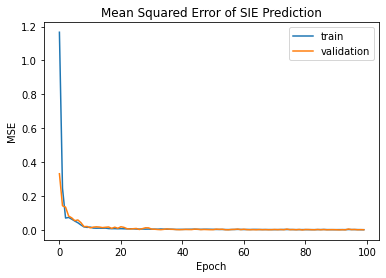

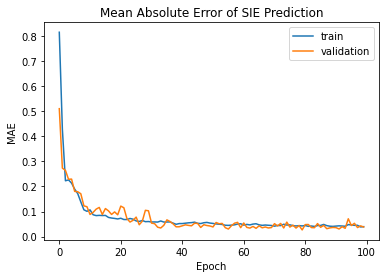

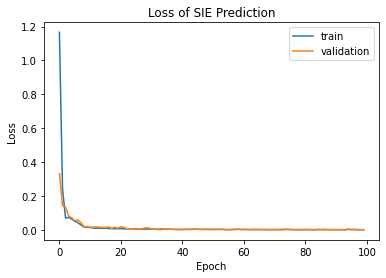

In [11]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('Mean Squared Error of SIE Prediction')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Mean Absolute Error of SIE Prediction')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss of SIE Prediction')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [12]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from numpy import sqrt

#model.load_weights("weights.best.hdf5")

cols = len(df.columns)
pred = model.predict(X_test)

predicted_dataset = dataset
predicted_dataset[len(predicted_dataset)-len(pred):, cols-1] = pred[:, 0]
scaled_predicted_dataset = scaler.inverse_transform(predicted_dataset)

predicted_df = df.copy()
predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):] = scaled_predicted_dataset[len(predicted_dataset)-len(pred):, cols-1]

predictions = pd.DataFrame()
predictions['predicted'] = (predicted_df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions['actual'] = (df['sea_ice_extent'][len(predicted_dataset)-len(pred):])
predictions = predictions.astype(float)

4/4 [==============================] - 2s 20ms/step


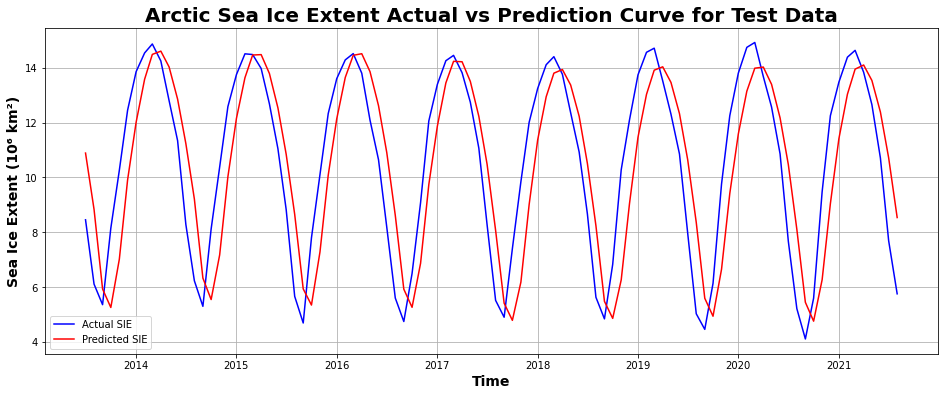

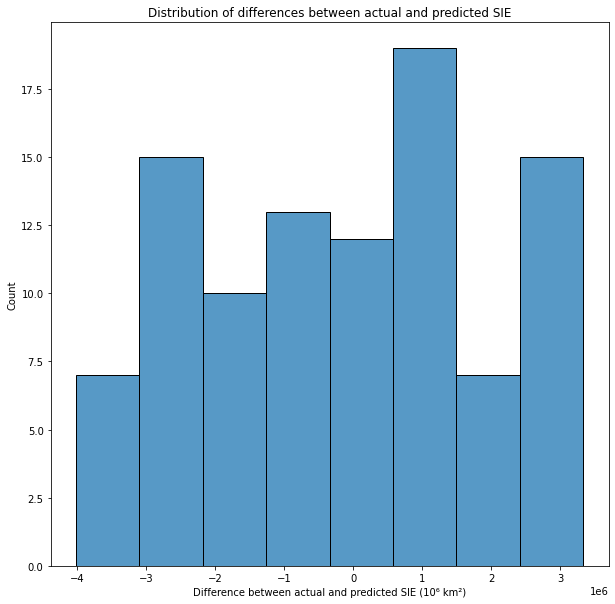

MSE :  4006753839860.0356 (10⁶ km²)
MSPE : 6.135 %
RMSE :  2001687.7478418145 (10⁶ km²)
RMSPE : 24.769 %
MAE :  1743191.724489796 (10⁶ km²)
MAPE :  20.156 %
R2 :  60.138


In [13]:
plt.figure(figsize = (16,6))
ax = plt.axes()
# ax.set_facecolor('#dcdcdc')

plt.title('Arctic Sea Ice Extent Actual vs Prediction Curve for Test Data', fontsize = 20,fontweight = "bold")
plt.xlabel('Time' , fontsize = 14,fontweight = "bold")
plt.ylabel('Sea Ice Extent (10\u2076 km\u00b2)', fontsize = 14,fontweight = "bold")
plt.plot(predictions['actual']/10**6, 'blue', label='Actual SIE')
plt.plot(predictions['predicted']/10**6, 'red', label='Predicted SIE')
plt.legend()
plt.grid()
plt.show

predictions['diff'] = predictions['predicted'] - predictions['actual']
plt.figure(figsize=(10,10))
plt.xlabel('Difference between actual and predicted SIE (10\u2076 km\u00b2)')
sns.histplot(predictions['diff'])
plt.title('Distribution of differences between actual and predicted SIE')
plt.show()

mspe = (np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values))) * 100
rmspe = (np.sqrt(np.mean(np.square((predictions['actual'].values - predictions['predicted'].values) / predictions['actual'].values)))) * 100

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MSPE :", round(mspe,3), "%")
print("RMSE : ", sqrt(mean_squared_error(predictions['predicted'].values, predictions['actual'].values)), "(10\u2076 km\u00b2)")
print("RMSPE :", round(rmspe,3), "%")
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['actual'].values), "(10\u2076 km\u00b2)")
print("MAPE : ", round(mean_absolute_percentage_error(predictions['predicted'].values, predictions['actual'].values)*100,3), "%")
print("R2 : ", round(r2_score(predictions['predicted'].values, predictions['actual'].values)*100,3))

In [14]:
# while True:pass